In [ ]:
!jupyter nbconvert --to html /content/colorado_motor_vehicle_sales1.ipynb

[NbConvertApp] WARNING | pattern 'colorado_motor_vehicle_sales1.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=T

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import os

In [ ]:
# Load the dataset
sales_data = pd.read_csv('colorado_motor_vehicle_sales.csv')
print(sales_data.head())

   year  quarter              county      sales
0  2008        1               Adams  231609000
1  2008        1            Arapahoe  550378000
2  2008        1  Boulder/Broomfield  176771000
3  2008        1              Denver  200103000
4  2008        1             Douglas   93259000


In [ ]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     501 non-null    int64 
 1   quarter  501 non-null    int64 
 2   county   501 non-null    object
 3   sales    501 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [ ]:
sales_data.head()

,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


In [ ]:
sales_data['Date'] = pd.to_datetime(sales_data['year'].astype(str) + '-Q' + sales_data['quarter'].astype(str))
sales_data.set_index('Date', inplace=True)

<ipython-input-6-9d1c8283a246>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales_data['Date'] = pd.to_datetime(sales_data['year'].astype(str) + '-Q' + sales_data['quarter'].astype(str))


In [ ]:
print("\nMissing values per column:")
print(sales_data.isnull().sum())


Missing values per column:
year       0
quarter    0
county     0
sales      0
dtype: int64



Shape of the DataFrame:
(501, 4)

Data types:
year        int64
quarter     int64
county     object
sales       int64
dtype: object

Missing values:
year       0
quarter    0
county     0
sales      0
dtype: int64

Summary statistics:
              year     quarter         sales
count   501.000000  501.000000  5.010000e+02
mean   2011.570858    2.502994  1.760585e+08
std       2.266599    1.120041  1.642055e+08
min    2008.000000    1.000000  6.274000e+06
25%    2010.000000    2.000000  6.148200e+07
50%    2012.000000    3.000000  1.385820e+08
75%    2014.000000    4.000000  2.241580e+08
max    2015.000000    4.000000  9.169100e+08


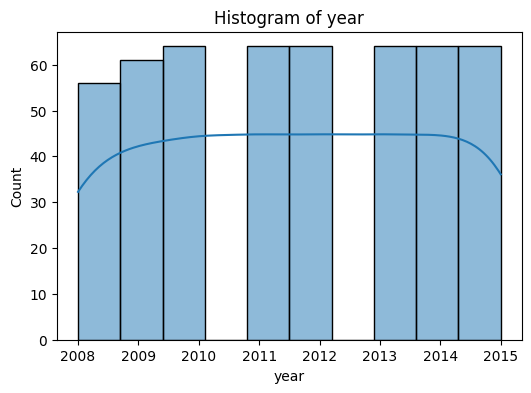

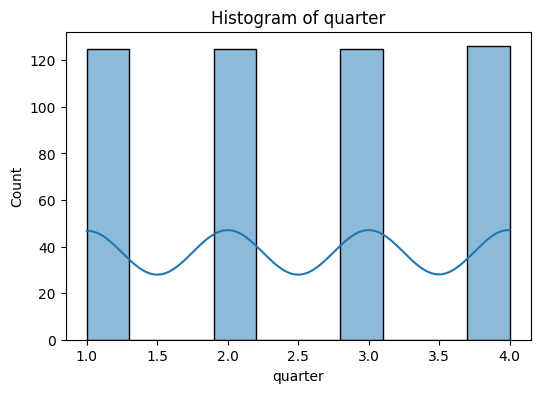

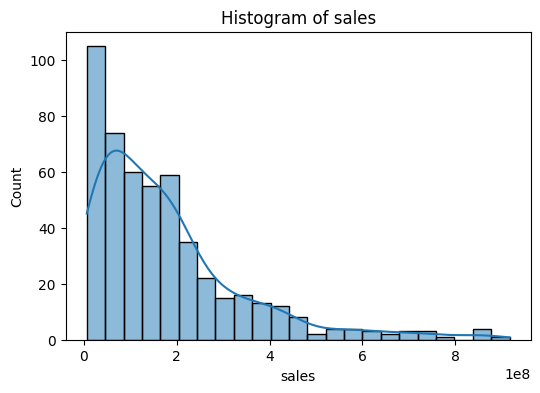

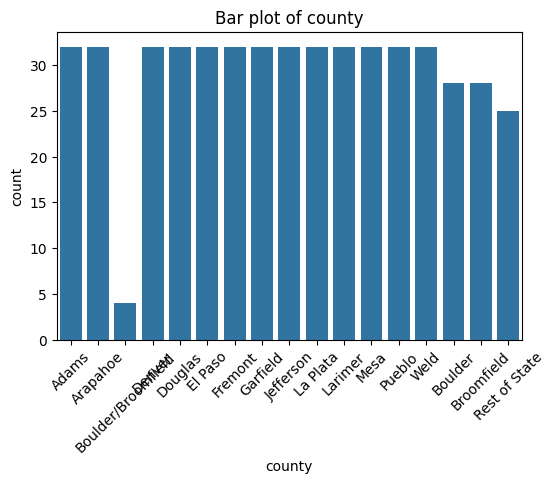

In [ ]:
# Exploratory Data Analysis (EDA)
def perform_eda(df):
    print("\nShape of the DataFrame:")
    print(df.shape)

    print("\nData types:")
    print(df.dtypes)

    print("\nMissing values:")
    print(df.isnull().sum())

    print("\nSummary statistics:")
    print(df.describe())

    # Plot histograms for numerical data
    for column in df.select_dtypes(include=[np.number]).columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f"Histogram of {column}")
        plt.show()

    # Bar plots for categorical data
    for column in df.select_dtypes(include=['object']).columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=column)
        plt.title(f"Bar plot of {column}")
        plt.xticks(rotation=45)
        plt.show()

perform_eda(sales_data)

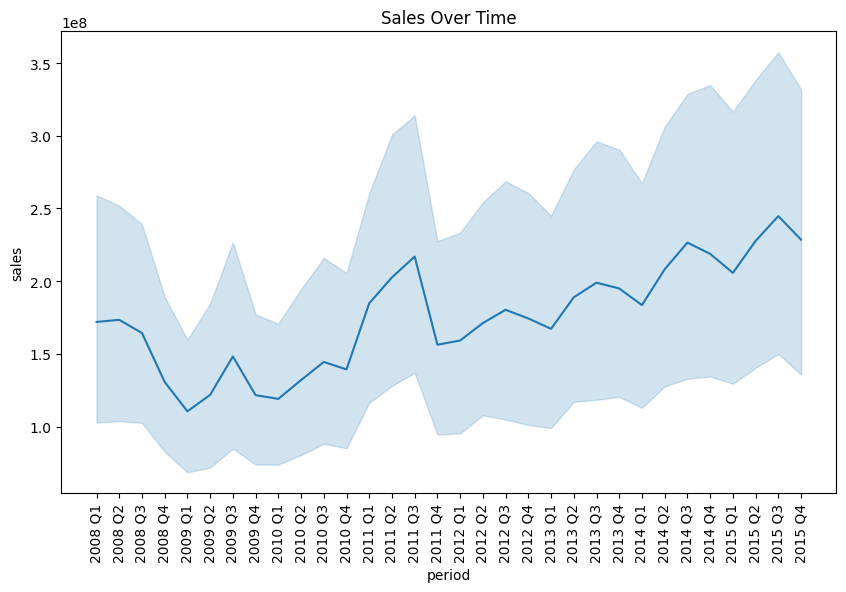

<ipython-input-25-eca6f0b35fd5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sales_data, x='quarter', y='sales', palette='Set3')


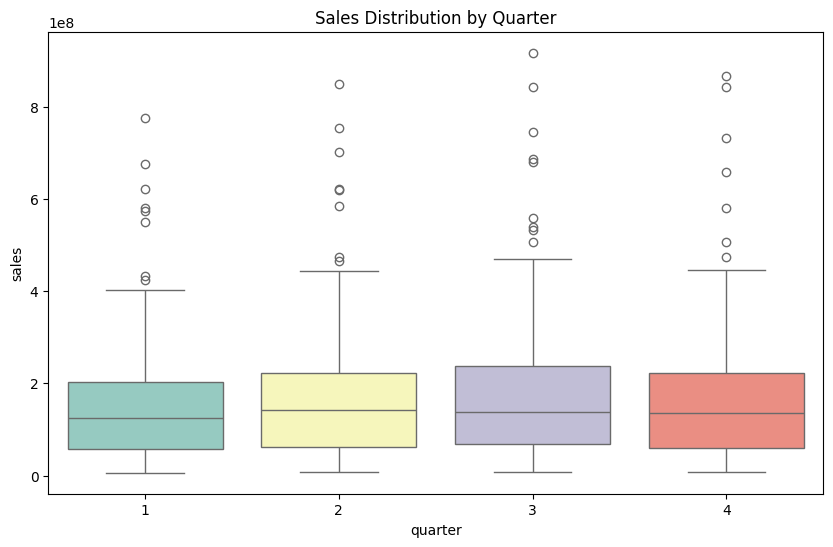

In [ ]:
sales_data['period'] = sales_data['year'].astype(str) + ' Q' + sales_data['quarter'].astype(str)

# Time series plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=sales_data, x='period', y='sales')
plt.title('Sales Over Time')
plt.xticks(rotation=90)
plt.show()

# Box plot by quarter

plt.figure(figsize=(10, 6))
sns.boxplot(data=sales_data, x='quarter', y='sales', palette='Set3')
plt.title('Sales Distribution by Quarter')
plt.show()

<ipython-input-24-d3faec256d81>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = sales_data[['sales']].resample('M').sum()


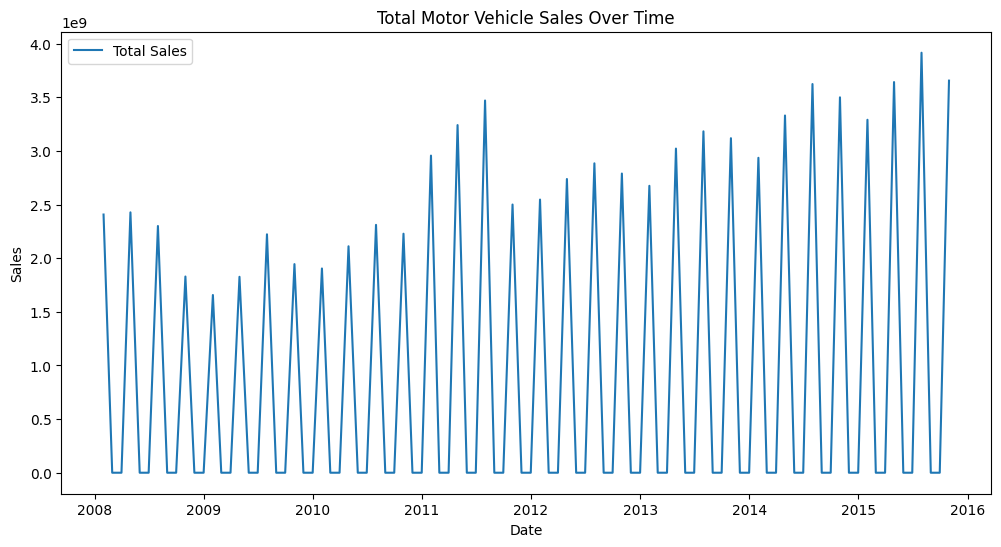

In [ ]:
# Time Series Analysis
monthly_sales = sales_data[['sales']].resample('M').sum()
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['sales'], label='Total Sales')
plt.title('Total Motor Vehicle Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

<ipython-input-21-3950af4022b5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sales_data.reset_index(), x='quarter', y='sales', palette='Set3')


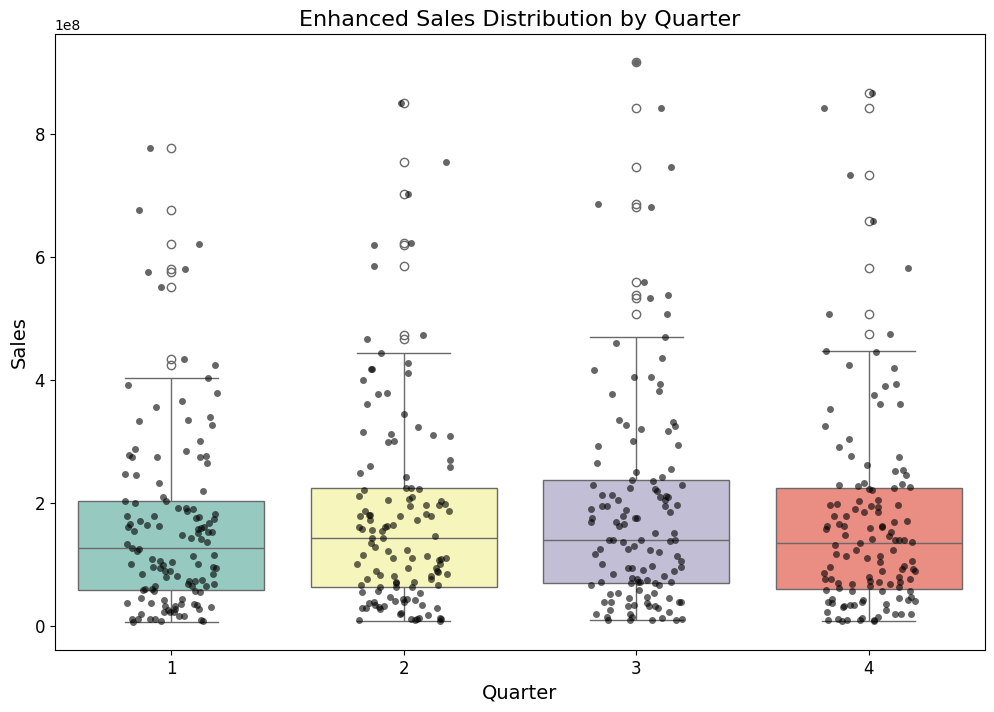

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=sales_data.reset_index(), x='quarter', y='sales', palette='Set3')
sns.stripplot(data=sales_data.reset_index(), x='quarter', y='sales', color='black', alpha=0.6, jitter=0.2)

# Add title and labels
plt.title('Enhanced Sales Distribution by Quarter', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()


<Figure size 1400x800 with 0 Axes>

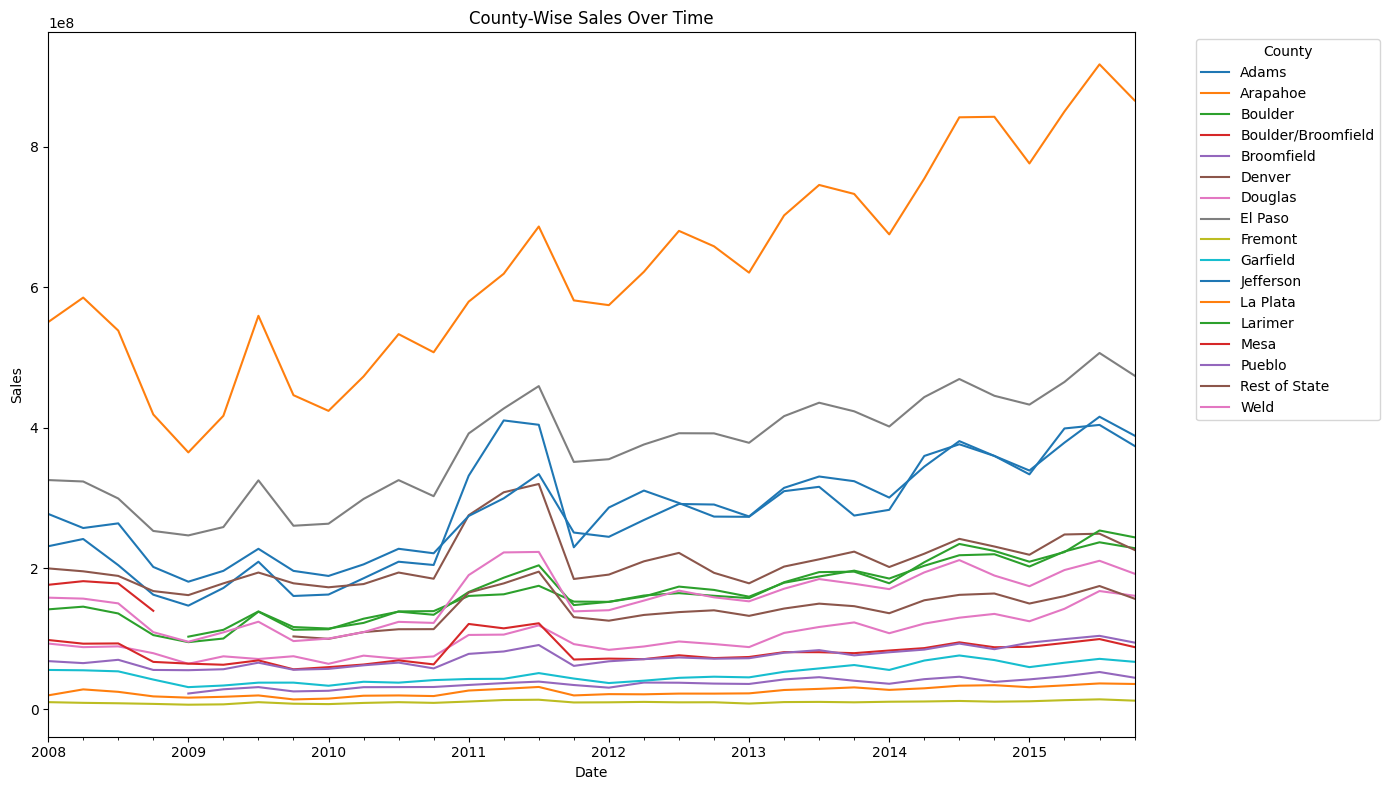

In [ ]:
# County-Wise Sales Over Time
plt.figure(figsize=(14, 8))
county_sales = sales_data.groupby(['Date', 'county'])['sales'].sum().unstack()
county_sales.plot(kind='line', figsize=(14, 8))
plt.title('County-Wise Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

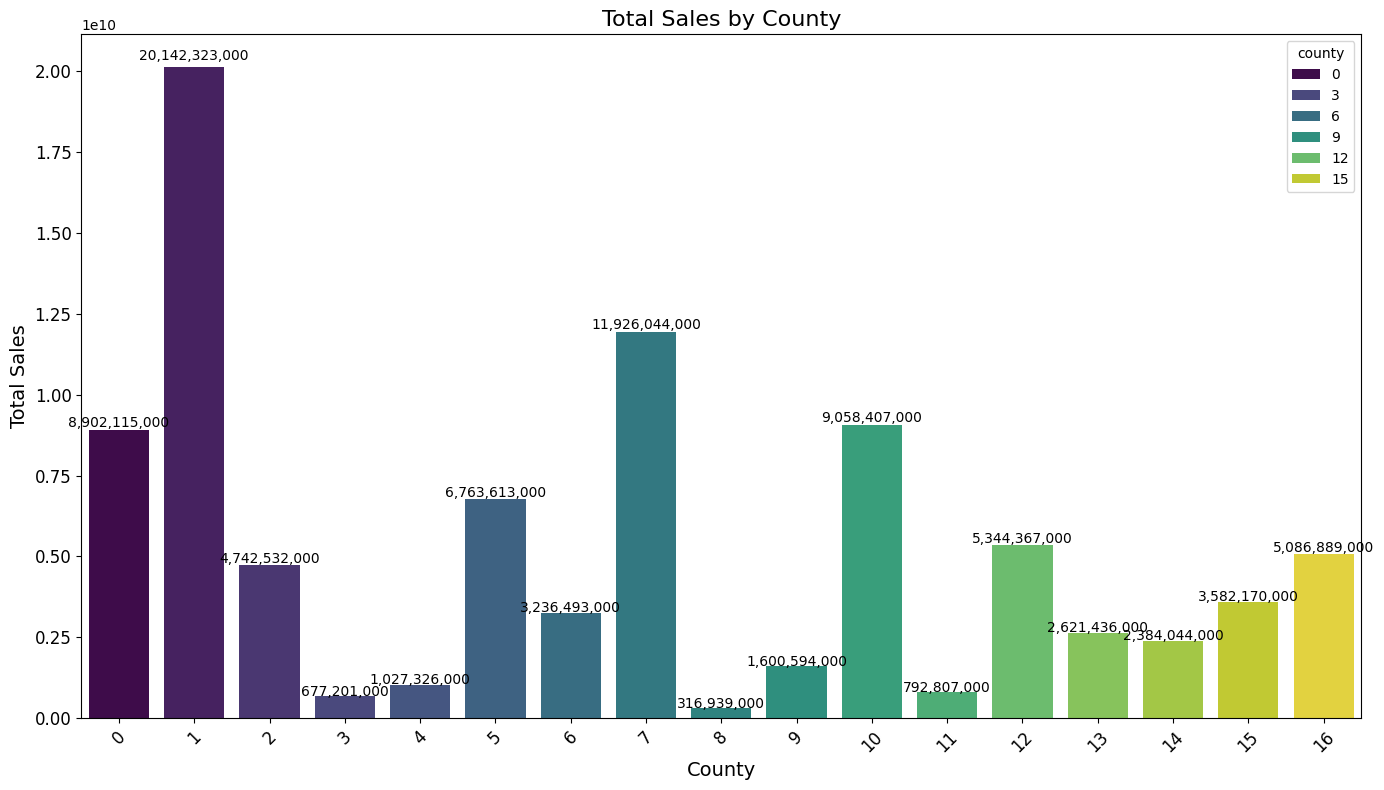

In [ ]:
# Aggregate sales by county
county_sales = sales_data.groupby('county')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=county_sales, x='county', y='sales', palette='viridis', hue='county')

# Add annotations for total sales
for index, row in county_sales.iterrows():
    plt.text(index, row['sales'] + row['sales'] * 0.01, f"{int(row['sales']):,}", ha='center', fontsize=10)

# Customize plot
plt.title('Total Sales by County', fontsize=16)
plt.xlabel('County', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import ipywidgets as widgets

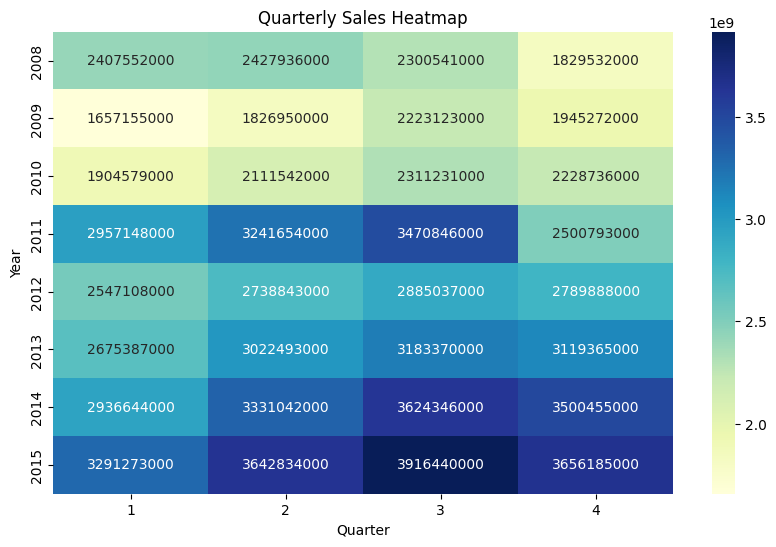

In [ ]:
# Quarterly Sales Heatmap
quarterly_sales = sales_data.pivot_table(index='year', columns='quarter', values='sales', aggfunc='sum')
plt.figure(figsize=(10, 6))
sns.heatmap(quarterly_sales, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Quarterly Sales Heatmap')
plt.xlabel('Quarter')
plt.ylabel('Year')
plt.show()

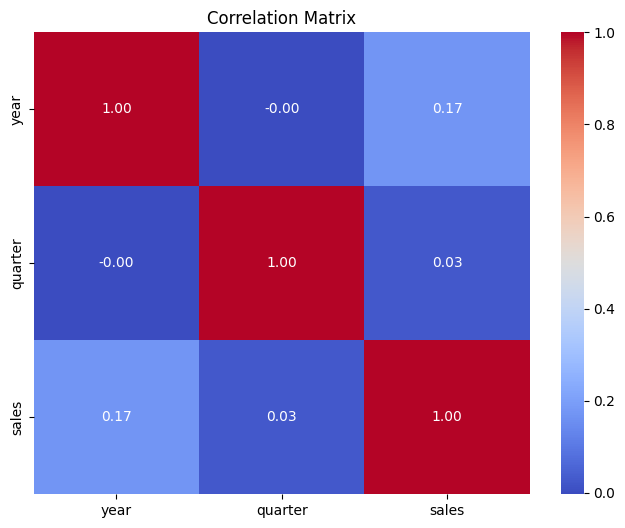

In [ ]:
# Correlation Analysis
"""plt.figure(figsize=(8, 6))
correlation_matrix = sales_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()"""

# Correlation Analysis
plt.figure(figsize=(8, 6))
# Select only numerical columns for correlation analysis
numerical_data = sales_data.select_dtypes(include=np.number)
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Statistical Analysis
try:
    decomposition = seasonal_decompose(monthly_sales['sales'], model='multiplicative', period=12)
    decomposition.plot()
    plt.show()
except Exception as e:
    print("Seasonal decomposition failed:", e)

Seasonal decomposition failed: Multiplicative seasonality is not appropriate for zero and negative values


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   94
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1903.418
Date:                Wed, 01 Jan 2025   AIC                           3818.836
Time:                        14:18:56   BIC                           3834.032
Sample:                    01-31-2008   HQIC                          3824.972
                         - 10-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9994      3.498     -0.286      0.775      -7.855       5.856
ar.L2         -0.9991      4.211     -0.237      0.812      -9.252       7.254
ar.L3          0.0250      4.201      0.006      0.9

<ipython-input-16-359e60a60ebd>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales.index[-1], periods=12, freq='M')


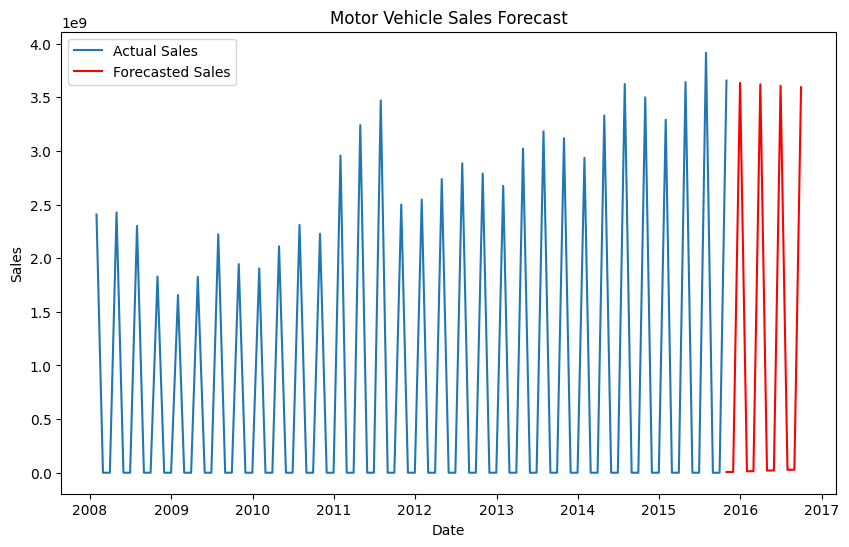

Mean Squared Error: 1.8404875062255548e+16


In [ ]:
# Predictive Modeling
try:
    model = ARIMA(monthly_sales['sales'], order=(5, 1, 0))
    model_fit = model.fit()
    print(model_fit.summary())

    forecast = model_fit.forecast(steps=12)
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_sales.index, monthly_sales['sales'], label='Actual Sales')
    future_dates = pd.date_range(start=monthly_sales.index[-1], periods=12, freq='M')
    plt.plot(future_dates, forecast, label='Forecasted Sales', color='red')
    plt.title('Motor Vehicle Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    mse = mean_squared_error(monthly_sales['sales'][-12:], forecast)
    print(f"Mean Squared Error: {mse}")
except Exception as e:
    print("ARIMA modeling failed:", e)


In [ ]:
try:
    # Convert 'county' to categorical codes
    sales_data['county'] = sales_data['county'].astype('category').cat.codes

    # Define features and target
    X = sales_data[['year', 'quarter', 'county']]
    y = sales_data['sales']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Random Forest RMSE: {rmse}")

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)

    # Best parameters and evaluation
    print(f"Best parameters: {grid_search.best_params_}")
    best_rf_model = grid_search.best_estimator_
    y_best_pred = best_rf_model.predict(X_test)
    best_rmse = np.sqrt(mean_squared_error(y_test, y_best_pred))
    print(f"Best Random Forest RMSE: {best_rmse}")

except Exception as e:
    print("Random Forest modeling failed:", e)


Random Forest RMSE: 20402876.97387048
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest RMSE: 19981856.206187755


In [ ]:
# Summary Report
report = f"""
Colorado Motor Vehicle Sales Data Analysis Report
=================================================
1. Data Overview
----------------
- Dataset includes {len(sales_data)} records spanning {sales_data.index.min()} to {sales_data.index.max()}.

2. Exploratory Data Analysis
----------------------------
- Histograms and bar plots provided insights into data distribution.
- Time series plots showed trends over time.
- Quarterly heatmaps and correlation matrices highlighted key patterns.

3. Statistical Analysis
-----------------------
- Seasonal decomposition revealed key seasonal patterns.

4. Predictive Modeling
----------------------
- ARIMA model evaluated with a Mean Squared Error of: {mse:.2f}.
- Random Forest model RMSE: {rmse:.2f}. Grid search tuning improved RMSE to: {best_rmse:.2f}.

5. Conclusions
--------------
- Analysis highlighted trends and seasonality in motor vehicle sales.
- Forecasting models are useful for planning and decision-making.
"""

print(report)


Colorado Motor Vehicle Sales Data Analysis Report
1. Data Overview
----------------
- Dataset includes 501 records spanning 2008-01-01 00:00:00 to 2015-10-01 00:00:00.

2. Exploratory Data Analysis
----------------------------
- Histograms and bar plots provided insights into data distribution.
- Time series plots showed trends over time.
- Quarterly heatmaps and correlation matrices highlighted key patterns.

3. Statistical Analysis
-----------------------
- Seasonal decomposition revealed key seasonal patterns.

4. Predictive Modeling
----------------------
- ARIMA model evaluated with a Mean Squared Error of: 18404875062255548.00.
- Random Forest model RMSE: 20402876.97. Grid search tuning improved RMSE to: 19981856.21.

5. Conclusions
--------------
- Analysis highlighted trends and seasonality in motor vehicle sales.
- Forecasting models are useful for planning and decision-making.

